In [43]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential



In [44]:
dir = './dataSources/'
labels = os.listdir(dir + '/Garbage classification/Garbage classification/')

In [45]:
dicts = []

for label in labels:
    directory = os.path.join(dir + '/Garbage classification/Garbage classification/', label)
    samples = os.listdir(directory)

    x = {'Type': label, 'Samples': len(samples)}
    dicts.append(x)


df = pd.DataFrame.from_dict(dicts)
df

,Type,Samples
0,cardboard,403
1,glass,501
2,metal,410
3,paper,594
4,plastic,482
5,trash,137


# Modelling

In [46]:
import pathlib
data_dir = pathlib.Path(os.path.join(dir, './Garbage classification/Garbage classification/'))
data_dir

WindowsPath('dataSources/Garbage classification/Garbage classification')

In [47]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


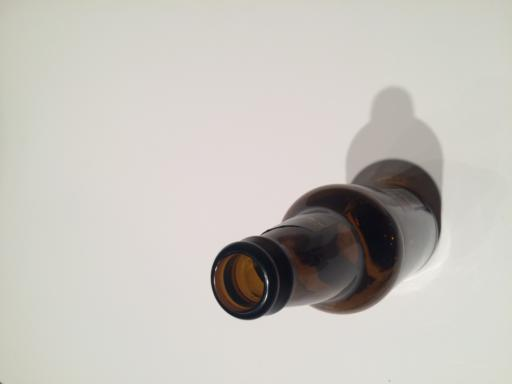

In [48]:
glass = list(data_dir.glob('glass/*'))
Image.open(str(glass[0]))

In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [52]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


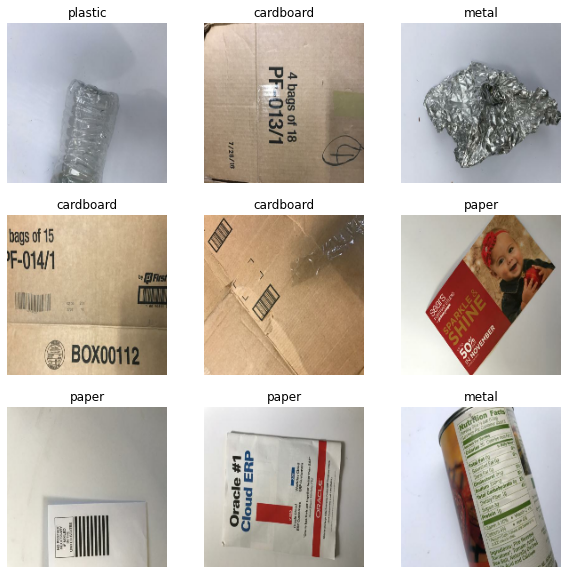

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [54]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
normalization_layer = layers.Rescaling(1./255)

In [57]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0014073207 0.98823553


# Create the model

In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

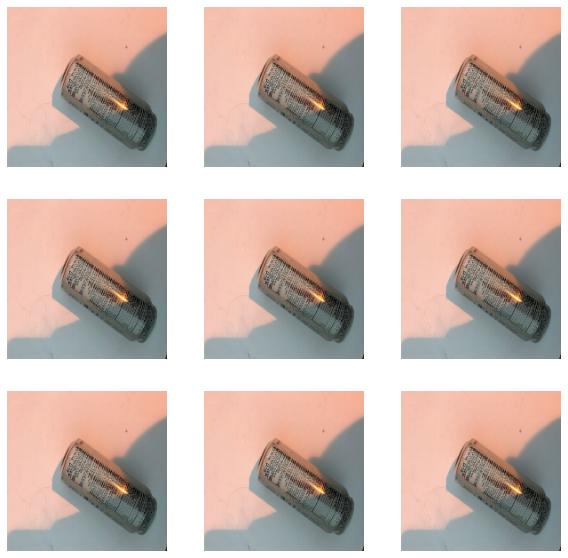

In [59]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [60]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
                                         patience=4, # how many epochs to wait before stopping
                                         restore_best_weights=True,)

In [61]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [63]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [64]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

model.save("/model/testmodel.h5")

Epoch 1/10
64/64 [==============================] - 25s 384ms/step - loss: 1.5413 - accuracy: 0.3467 - val_loss: 1.3721 - val_accuracy: 0.4396
Epoch 2/10
64/64 [==============================] - 22s 351ms/step - loss: 1.3476 - accuracy: 0.4525 - val_loss: 1.3260 - val_accuracy: 0.4812
Epoch 3/10
64/64 [==============================] - 22s 344ms/step - loss: 1.1976 - accuracy: 0.5331 - val_loss: 1.0937 - val_accuracy: 0.5624
Epoch 4/10
64/64 [==============================] - 22s 351ms/step - loss: 1.2190 - accuracy: 0.5148 - val_loss: 1.2094 - val_accuracy: 0.4950
Epoch 5/10
64/64 [==============================] - 23s 362ms/step - loss: 1.1196 - accuracy: 0.5732 - val_loss: 1.0577 - val_accuracy: 0.6059
Epoch 6/10
64/64 [==============================] - 23s 361ms/step - loss: 0.9771 - accuracy: 0.6296 - val_loss: 1.0216 - val_accuracy: 0.6040
Epoch 7/10
64/64 [==============================] - 23s 356ms/step - loss: 0.9567 - accuracy: 0.6395 - val_loss: 1.0059 - val_accuracy: 0.6119

Minimum validation loss: 0.9969686269760132


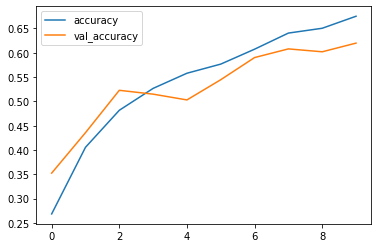

In [73]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [74]:
img = Image.open('./dataSources/Alu_ml.jpg')
img.size

(1000, 525)

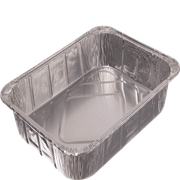

In [75]:
from PIL.Image import Resampling

img = img.resize((180, 180), Resampling.LANCZOS)
img

In [76]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.convert_to_tensor(img_array[:,:,:3])
img_array.shape

TensorShape([180, 180, 3])

In [77]:
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(    "This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 75ms/step
This image most likely belongs to metal with a 37.82 percent confidence.


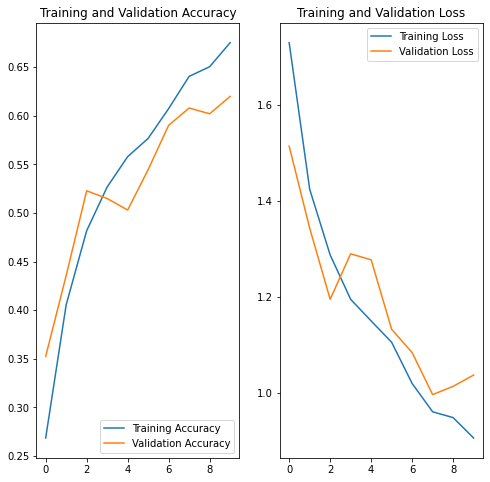

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [79]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


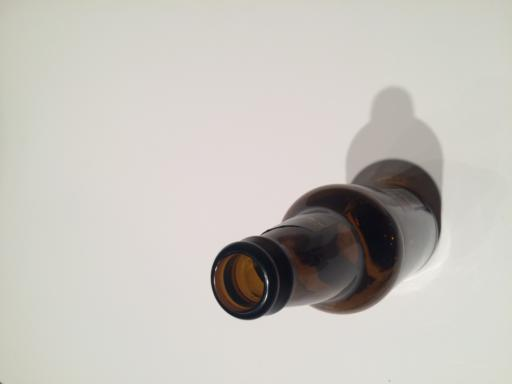

In [80]:
glass = list(data_dir.glob('glass/*'))
Image.open(str(glass[0]))

In [81]:
batch_size = 32
img_height = 180
img_width = 180

In [82]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [83]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [84]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


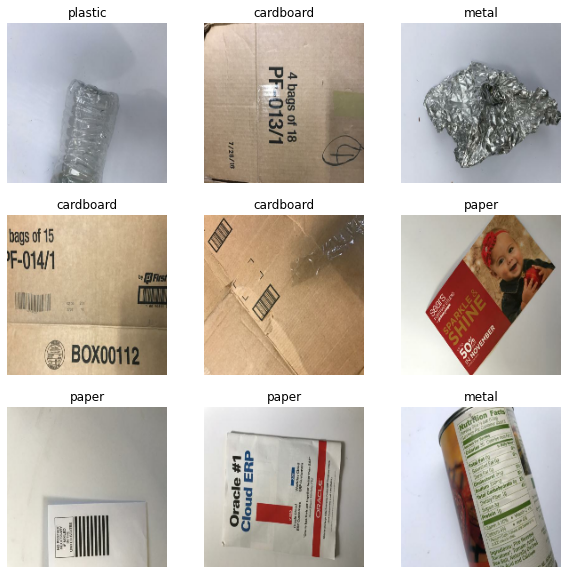

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [86]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [87]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
normalization_layer = layers.Rescaling(1./255)

In [89]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9686275


# Create the model

In [90]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

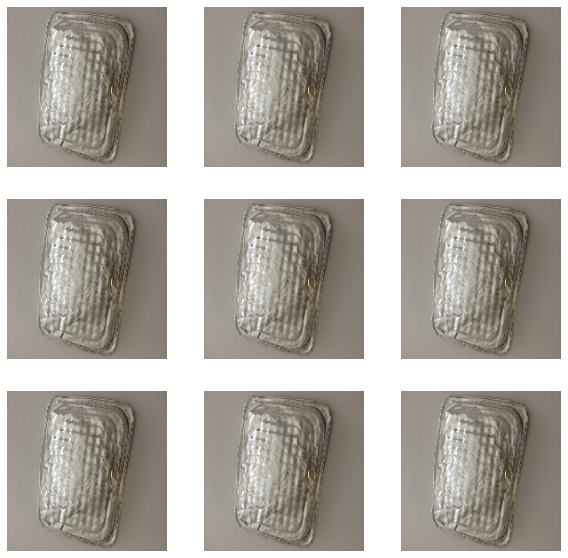

In [91]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [92]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
                                         patience=4, # how many epochs to wait before stopping
                                         restore_best_weights=True,)

In [93]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [95]:
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [96]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

model.save("/model/testmodel.h5")

Epoch 1/10
64/64 [==============================] - 24s 369ms/step - loss: 1.6290 - accuracy: 0.3333 - val_loss: 1.3854 - val_accuracy: 0.4337
Epoch 2/10
64/64 [==============================] - 24s 368ms/step - loss: 1.3657 - accuracy: 0.4382 - val_loss: 1.3281 - val_accuracy: 0.4851
Epoch 3/10
58/64 [==========================>...] - ETA: 2s - loss: 1.2531 - accuracy: 0.5022


KeyboardInterrupt



In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
img = Image.open('./dataSources/Alu_ml.jpg')
img.size

In [ ]:
from PIL.Image import Resampling

img = img.resize((180, 180), Resampling.LANCZOS)
img

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.convert_to_tensor(img_array[:,:,:3])
img_array.shape

In [ ]:
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(    "This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Modelling

In [ ]:
import pathlib
data_dir = pathlib.Path(os.path.join(dir, './Garbage classification/Garbage classification/'))
data_dir

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

In [ ]:
glass = list(data_dir.glob('glass/*'))
Image.open(str(glass[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Create the model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
                                         patience=4, # how many epochs to wait before stopping
                                         restore_best_weights=True,)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
img = Image.open('./dataSources/Alu_ml.jpg')
img.size

In [ ]:
from PIL.Image import Resampling

img = img.resize((180, 180), Resampling.LANCZOS)
img

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.convert_to_tensor(img_array[:,:,:3])
img_array.shape

In [ ]:
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(    "This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

In [ ]:
glass = list(data_dir.glob('glass/*'))
Image.open(str(glass[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Create the model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
                                         patience=4, # how many epochs to wait before stopping
                                         restore_best_weights=True,)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
img = Image.open('./dataSources/Alu_ml.jpg')
img.size

In [ ]:
from PIL.Image import Resampling

img = img.resize((180, 180), Resampling.LANCZOS)
img

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.convert_to_tensor(img_array[:,:,:3])
img_array.shape

In [ ]:
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(    "This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
